# The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

This notebook will be dedicated to estimating parameters within some __simulated data__.

In [1]:
%config IPCompleter.use_jedi = False
import torch as t
import pyro

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

t.set_default_tensor_type(t.DoubleTensor)

In [283]:
## starting with just one P b/c I am struggling w/ python rustiness and filepaths
from dfply import *
import glob
import pandas as pd

## just to get the skeleton of the final data format
df_raw = pd.read_csv("osfstorage-archive/Experiment 2/PrEstExp_001_111218_115935.csv")
df = (df_raw >> 
      group_by(X.querytype) >> 
      summarize(estimate = X.estimate.mean()) >>
      mutate(estimate = X.estimate/100.)
     )

In [358]:

trial_funcs = dict({
    "AandB": lambda theta: t.matmul(theta, t.tensor([1.,0.,0.,0.])) ,
    "AandnotB": lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,0.])),
    "notAandB": lambda theta: t.matmul(theta, t.tensor([0.,0.,1.,0.])),
    "notAandnotB": lambda theta: t.matmul(theta, t.tensor([0.,0.,0.,1.])),
    "A":lambda theta: t.matmul(theta, t.tensor([1.,1.,0.,0.])),
    "B":lambda theta: t.matmul(theta, t.tensor([1.,0.,1.,0.])),
    "notA":lambda theta: t.matmul(theta, t.tensor([0.,0.,1.,1.])),
    "notB":lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,1.])),
    "AorB":lambda theta: t.matmul(theta, t.tensor([1.,1.,1.,0.])),
    "AornotB":lambda theta: t.matmul(theta, t.tensor([1.,1.,0.,1.])),
    "notAorB":lambda theta: t.matmul(theta, t.tensor([0.,1.,1.,1.])),
    "notAornotB":lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,1.])),
    
    "AgB": lambda theta: t.div( t.matmul(theta, t.tensor([1.,0.,0.,0.])), t.matmul(theta, t.tensor([1.,0.,1.,0.])) ),
    "notAgB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,1.,0.])), t.matmul(theta, t.tensor([1.,0.,1.,0.])) ),
    "AgnotB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,1.,0.,0.])), t.matmul(theta, t.tensor([0.,1.,0.,1.])) ),
    "notAgnotB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,0.,1.])), t.matmul(theta, t.tensor([0.,1.,0.,1.])) ),
    "BgA": lambda theta: t.div( t.matmul(theta, t.tensor([1.,0.,0.,0.])), t.matmul(theta, t.tensor([1.,1.,0.,0.])) ),
    "notBgA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,1.,0.,0.])), t.matmul(theta, t.tensor([1.,1.,0.,0.])) ),
    "BgnotA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,1.,0.])), t.matmul(theta, t.tensor([0.,0.,1.,1.])) ),
    "notBgnotA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,0.,1.])), t.matmul(theta, t.tensor([0.,0.,1.,1.])) )
})


def dm_probs(trial_data, theta, n_obs):
    ## compute implied subj. probability from latent theta and trial type
    ## this is a vectorized solution: https://bit.ly/2P6mMcD
    p = t.tensor([])
    for i in range(0, n_obs):
        temp = trial_funcs[trial_data[i]](theta)
        p = t.cat( (p, t.tensor([temp])), 0)

    return p


## Simulate data

## create and fit model

k is relatively independent of both Beta and k though, so that's good.

In [323]:
## ------
## simulate data into pandas DataFrame
## -------
n_participants = 3
n_blocks = 2

trial_types = list(df.querytype)

n_trial_types = len(trial_types)

trials = trial_types*n_blocks
blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
all_trials = trials*n_participants
all_blocks = blocks*n_participants
all_responses = t.ones(0)

all_thetas = []

for i in range(0, n_participants):
    theta = dist.Dirichlet(t.ones(4)).sample()

    probs = dm_probs(trials, theta, len(trials))
    responses = sim_sampling(probs, beta=1, N=10, k=100)
    
    all_thetas.append(theta)
    all_responses = t.cat((all_responses, responses))

sim_data = pd.DataFrame(
    data = {
        "ID": all_participants,
        "querytype": all_trials, 
        "block": all_blocks,
        "response": all_responses
    }
)

sim_data

,ID,querytype,block,response
0,0,A,0,0.256709
1,0,AandB,0,0.201486
2,0,AandnotB,0,0.216847
3,0,AgB,0,0.300816
4,0,AgnotB,0,0.296008
...,...,...,...,...
115,2,notAorB,1,0.661045
116,2,notAornotB,1,0.571399
117,2,notB,1,0.619435
118,2,notBgA,1,0.672552


In [394]:
#### new API

### first make a design matrix

num_vecs = dict({
    "AandB": t.tensor([1.,0.,0.,0.]),
    "AandnotB": t.tensor([0.,1.,0.,0.]),
    "notAandB": t.tensor([0.,0.,1.,0.]),
    "notAandnotB": t.tensor([0.,0.,0.,1.]),
    "A":t.tensor([1.,1.,0.,0.]),
    "B":t.tensor([1.,0.,1.,0.]),
    "notA":t.tensor([0.,0.,1.,1.]),
    "notB":t.tensor([0.,1.,0.,1.]),
    "AorB":t.tensor([1.,1.,1.,0.]),
    "AornotB":t.tensor([1.,1.,0.,1.]),
    "notAorB":t.tensor([0.,1.,1.,1.]),
    "notAornotB":t.tensor([0.,1.,0.,1.]),
   
    "AgB": t.tensor([1.,0.,0.,0.]),
    "notAgB": t.tensor([0.,0.,1.,0.]),
    "AgnotB": t.tensor([0.,1.,0.,0.]),
    "notAgnotB": t.tensor([0.,0.,0.,1.]),
    "BgA": t.tensor([1.,0.,0.,0.]),
    "notBgA": t.tensor([0.,1.,0.,0.]),
    "BgnotA": t.tensor([0.,0.,1.,0.]),
    "notBgnotA": t.tensor([0.,0.,0.,1.])
})

denom_vecs = dict({
    "AandB":  t.tensor([1.,1.,1.,1.]),
    "AandnotB":  t.tensor([1.,1.,1.,1.]),
    "notAandB":  t.tensor([1.,1.,1.,1.]),
    "notAandnotB":  t.tensor([1.,1.,1.,1.]),
    "A": t.tensor([1.,1.,1.,1.]),
    "B": t.tensor([1.,1.,1.,1.]),
    "notA": t.tensor([1.,1.,1.,1.]),
    "notB": t.tensor([1.,1.,1.,1.]),
    "AorB": t.tensor([1.,1.,1.,1.]),
    "AornotB": t.tensor([1.,1.,1.,1.]),
    "notAorB": t.tensor([1.,1.,1.,1.]),
    "notAornotB": t.tensor([1.,1.,1.,1.]),
    
    "AgB": t.tensor([1.,0.,1.,0.]),
    "notAgB": t.tensor([1.,0.,1.,0.]),
    "AgnotB": t.tensor([0.,1.,0.,1.]),
    "notAgnotB": t.tensor([0.,1.,0.,1.]),
    "BgA": t.tensor([1.,1.,0.,0.]),
    "notBgA": t.tensor([1.,1.,0.,0.]),
    "BgnotA": t.tensor([0.,0.,1.,1.]),
    "notBgnotA": t.tensor([0.,0.,1.,1.])
})

trial_list = list(sim_data.querytype)
X_num = t.stack([num_vecs[trial] for trial in trial_list])
X_denom = t.stack([denom_vecs[trial] for trial in trial_list])

test_data2 = {
    "trial": trial_list,
    "X_num": X_num,
    "X_denom": X_denom,
    "subj": list(sim_data.ID),
    "block": list(sim_data.block),
    "obs": t.tensor(list(sim_data.response))
}

test_info2 = {"n_Ps":n_participants, "n_blocks":n_blocks, "n_trials":20}

def bayesian_sampler(data):

    n_Ps = len(np.unique(data["subj"]))
    trial = data["trial"]
    subj = data["subj"]

    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    k = pyro.sample("k", dist.HalfCauchy(10)) ## noise, all causes

    # need a theta per person/querytype 
    with pyro.plate("subj", n_Ps):
        theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
        
    numerator = t.sum(theta[...,subj,:]*data["X_num"], dim=-1) # the indexing is the key!!!!!
    denom = t.sum(theta[...,subj,:]*data["X_denom"], dim=-1)
    pi = t.div(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)

    with pyro.plate("data"):
        yhat = pyro.sample("yhat", dist.Beta(p_bs*k, (1.-p_bs)*k), obs=data["obs"])
    
    return yhat


# bayesian_sampler(test_data2, test_info2)

## the shapes being right seems to be a necessary but not sufficient condition for this working
trace = pyro.poutine.trace(bayesian_sampler).get_trace(test_data2)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())


Trace Shapes:        
 Param Sites:        
Sample Sites:        
    beta dist     |  
        value     |  
     log_prob     |  
       N dist     |  
        value     |  
     log_prob     |  
       k dist     |  
        value     |  
     log_prob     |  
    subj dist     |  
        value   3 |  
     log_prob     |  
   theta dist   3 | 4
        value   3 | 4
     log_prob   3 |  
    yhat dist 120 |  
        value 120 |  
     log_prob 120 |  


In [396]:
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store()

nuts_kernel = NUTS(bayesian_sampler, adapt_step_size=True)
mcmc2 = MCMC(nuts_kernel, num_samples=500, warmup_steps=250)

mcmc2.run(test_data2)
mcmc2.summary()

Sample: 100%|██████████| 750/750 [01:43,  7.22it/s, step size=7.01e-02, acc. prob=0.945]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.59      0.70      0.38      0.01      1.28    232.60      1.00
         N      4.98      6.03      3.21      0.26     10.38    238.82      1.00
         k    102.49     13.67    100.96     78.83    123.01    343.22      1.00
theta[0,0]      0.10      0.01      0.10      0.09      0.11    482.18      1.00
theta[0,1]      0.16      0.01      0.16      0.14      0.17    527.11      1.00
theta[0,2]      0.27      0.01      0.27      0.25      0.29    476.44      1.00
theta[0,3]      0.47      0.02      0.47      0.44      0.50    419.03      1.00
theta[1,0]      0.15      0.01      0.15      0.13      0.16    486.40      1.00
theta[1,1]      0.11      0.01      0.11      0.09      0.13    524.32      1.00
theta[1,2]      0.09      0.01      0.09      0.07      0.10    481.72      1.00
theta[1,3]      0.66      0.02      0.66      0.63      0.69    364.48      1.00
theta[2,0]      0.32      0

In [397]:
all_thetas

[tensor([0.1021, 0.1555, 0.2950, 0.4475]),
 tensor([0.1576, 0.1204, 0.0973, 0.6247]),
 tensor([0.3442, 0.5554, 0.0254, 0.0750])]

it works! and much faster

In [399]:
from pyro.infer import Predictive

posterior_samples = mcmc2.get_samples()
posterior_predictive = Predictive(bayesian_sampler, posterior_samples)(
    test_data2
)
prior = Predictive(bayesian_sampler, num_samples=250)(
    test_data2
)

pyro_data = az.from_pyro(
    mcmc2,
    prior=prior, # don't need these for WAIC but might for other things
    posterior_predictive=posterior_predictive,
    coords={"yhat": np.arange(test_data2["obs"].shape[0])},
    dims={"data": ["yhat"]}
)

pyro_data
az.waic(pyro_data)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 500 by 120 log-likelihood matrix

          Estimate       SE
elpd_waic   202.66     7.34
p_waic        9.77        -

There has been a warning during the calculation. Please check the results.

## Simulating drawing mental samples

Instead of writing things in terms of the expectation with an arbitrary noise parameter K, could also imagine that trial-by-trial variability is a product of the mental sampling procedure. Here's how that would look for a single person/query.

<AxesSubplot:ylabel='Count'>

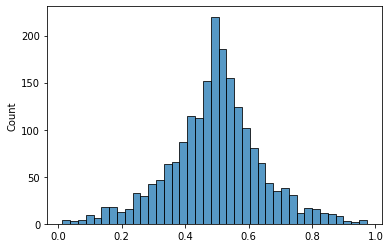

In [99]:
def bsampler(query):
    beta = pyro.sample("beta", dist.HalfCauchy(1))
    N = pyro.sample("N", dist.HalfCauchy(5))
    theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
    
    p = t.dot(theta, query)
    
    pi = pyro.sample("pi", dist.Beta(p*N, p*N))
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

sns.histplot(np.array([bsampler(t.tensor([1.,1.,0.,0.])) for _ in range(2000)]))

In [400]:
def bayesian_sampler2(data):

    n_Ps = len(np.unique(data["subj"]))
    trial = data["trial"]
    subj = data["subj"]

    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    k = pyro.sample("k", dist.HalfCauchy(10)) ## noise, all causes

    # need a theta per person/querytype 
    with pyro.plate("subj", n_Ps):
        theta = pyro.sample("theta", dist.Dirichlet(t.ones(4)))
        
    numerator = t.sum(theta[...,subj,:]*data["X_num"], dim=-1) # the indexing is the key!!!!!
    denom = t.sum(theta[...,subj,:]*data["X_denom"], dim=-1) # indexing like this is more natural and works!
    p_latent = t.div(numerator, denom)

    with pyro.plate("obs", len(data["obs"])):
        pi = pyro.sample("pi", dist.Beta(p_latent*N, (1-p_latent)*N))
        p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
#         p_bs = p_bs.unsqueeze(-1)
        yhat = pyro.sample("yhat", dist.Normal(p_bs, t.tensor(.01)), obs=data["obs"])
    
    return yhat

bayesian_sampler2(test_data2).shape

torch.Size([120])

In [402]:
trace = pyro.poutine.trace(bayesian_sampler2).get_trace(test_data2)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:        
 Param Sites:        
Sample Sites:        
    beta dist     |  
        value     |  
     log_prob     |  
       N dist     |  
        value     |  
     log_prob     |  
       k dist     |  
        value     |  
     log_prob     |  
    subj dist     |  
        value   3 |  
     log_prob     |  
   theta dist   3 | 4
        value   3 | 4
     log_prob   3 |  
     obs dist     |  
        value 120 |  
     log_prob     |  
      pi dist 120 |  
        value 120 |  
     log_prob 120 |  
    yhat dist 120 |  
        value 120 |  
     log_prob 120 |  


In [403]:
def sim_sampling2(p, beta, N):
    pi = dist.Beta(p*N, (1-p)*N).sample()
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    return p_bs

n_participants = 5
n_blocks = 3

trial_types = list(df.querytype)

n_trial_types = len(trial_types)

trials = trial_types*n_blocks
blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
all_trials = trials*n_participants
all_blocks = blocks*n_participants
all_responses = t.ones(0)

all_thetas = []

for i in range(0, n_participants):
    theta = dist.Dirichlet(t.ones(4)).sample()

    probs = dm_probs(trials, theta, len(trials))
    responses = sim_sampling2(probs, beta=1, N=10)
    
    all_thetas.append(theta)
    all_responses = t.cat((all_responses, responses))

sim_data = pd.DataFrame(
    data = {
        "ID": all_participants,
        "querytype": all_trials, 
        "block": all_blocks,
        "response": all_responses
    }
)

sim_data.head()

,ID,querytype,block,response
0,0,A,0,0.566841
1,0,AandB,0,0.599170
2,0,AandnotB,0,0.085701
3,0,AgB,0,0.908632
4,0,AgnotB,0,0.094974


In [406]:
trial_list = list(sim_data.querytype)
X_num = t.stack([num_vecs[trial] for trial in trial_list])
X_denom = t.stack([denom_vecs[trial] for trial in trial_list])

test_data2 = {
    "trial": trial_list,
    "X_num": X_num,
    "X_denom": X_denom,
    "subj": list(sim_data.ID),
    "block": list(sim_data.block),
    "obs": t.tensor(list(sim_data.response))
}

In [408]:
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store()

nuts_kernel = NUTS(bayesian_sampler2, jit_compile=True, ignore_jit_warnings=True, adapt_step_size=True)
mcmc2 = MCMC(nuts_kernel, num_samples=500, warmup_steps=250)

mcmc2.run(test_data2)
mcmc2.summary()

Sample: 100%|██████████| 750/750 [03:34,  3.49it/s, step size=5.39e-02, acc. prob=0.932]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.90      0.08      0.90      0.79      1.06    106.24      1.00
         N      8.76      0.85      8.78      7.38     10.12     81.76      1.00
         k     72.01    645.50     11.25      0.03     74.39    497.83      1.00
theta[0,0]      0.54      0.03      0.54      0.50      0.59    419.49      1.00
theta[0,1]      0.06      0.01      0.06      0.05      0.09    366.43      1.01
theta[0,2]      0.02      0.01      0.01      0.01      0.02     51.57      1.01
theta[0,3]      0.38      0.03      0.38      0.34      0.43    412.16      1.00
theta[1,0]      0.59      0.03      0.58      0.54      0.63    317.40      1.00
theta[1,1]      0.05      0.01      0.05      0.03      0.07    329.89      1.00
theta[1,2]      0.01      0.00      0.01      0.01      0.02     93.68      1.03
theta[1,3]      0.35      0.03      0.35      0.30      0.40    401.01      1.00
theta[2,0]      0.37      0

In [222]:
all_thetas

[tensor([0.0329, 0.0915, 0.2172, 0.6585]),
 tensor([0.1090, 0.3462, 0.2278, 0.3170]),
 tensor([0.1390, 0.2990, 0.5107, 0.0513]),
 tensor([0.0929, 0.0824, 0.4148, 0.4099]),
 tensor([0.1161, 0.2672, 0.4104, 0.2063])]

it works!

In [409]:
from pyro.infer import Predictive

posterior_samples = mcmc2.get_samples()
posterior_predictive = Predictive(bayesian_sampler2, posterior_samples)(
    test_data2
)
prior = Predictive(bayesian_sampler2, num_samples=250)(
    test_data2
)

pyro_data = az.from_pyro(
    mcmc2,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"y": np.arange(test_data2["obs"].shape[0])},
    dims={"obs": ["y"]}
)

# pyro_data

# after run mcmc
# pyro_data = az.from_pyro(mcmc2, log_likelihood=True)

pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [228]:
az.stats.waic(pyro_data)


TypeError: log likelihood not found in inference data object

## old way I was doing things, ignore (most likely)

In [37]:
def sim_sampling(p, beta, N, k):
    p_bs = p * N / (N + 2.*beta) + beta/(N + 2.*beta)
    return dist.Beta(p_bs*k, (1-p_bs)*k).sample()

## ------
## simulate data into pandas DataFrame
## -------
n_participants = 20
n_blocks = 3

trial_types = list(df.querytype)

n_trial_types = len(trial_types)

trials = trial_types*n_blocks
blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
all_trials = trials*n_participants
all_blocks = blocks*n_participants
all_responses = t.ones(0)

all_thetas = []

for i in range(0, n_participants):
    theta = dist.Dirichlet(t.ones(4)).sample()

    probs = dm_probs(trials, theta, len(trials))
    responses = sim_sampling(probs, beta=1, N=10, k=100)
    
    all_thetas.append(theta)
    all_responses = t.cat((all_responses, responses))

sim_data = pd.DataFrame(
    data = {
        "ID": all_participants,
        "querytype": all_trials, 
        "block": all_blocks,
        "response": all_responses
    }
)

sim_data.head()

,ID,querytype,block,response
0,0,A,0,0.741442
1,0,AandB,0,0.124305
2,0,AandnotB,0,0.724914
3,0,AgB,0,0.420885
4,0,AgnotB,0,0.838979


In [38]:
## now munge pandas dataframe into what is fed into model
def sort_trials(trial_data, observations):
    output = dict()
    for key in set(trial_data):
        output[key] = t.ones(0)
        
    for i in range(0, len(trial_data)):
        output[trial_data[i]] = t.cat( (output[trial_data[i]], t.tensor([observations[i]])) )
        
    return output

test_data = sort_trials(sim_data.querytype, sim_data.response)
test_info = {"n_Ps":n_participants, "n_blocks":n_blocks}

In [39]:
## define model -- need to come up with better practices regarding the munging of data and modeling

def bayesian_sampler(data, info):

    n_obs = len(data["A"])
    n_total_obs = len(data.keys())*n_obs
    n_Ps = info["n_Ps"]
    n_blocks = info["n_blocks"]

    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    k = pyro.sample("k", dist.HalfCauchy(10)) ## noise, all causes

    # need a theta per person/querytype (yes?)    

    thetas = [pyro.sample("theta_{}".format(j), dist.Dirichlet(t.ones(4))) for j in range(0,n_Ps)]
    theta = t.stack(thetas) # this works, not 100% sure if it's necessary vs just creating a n x 4 dirichlet

    for trial in data.keys():
        f = trial_funcs[trial]
        pi = f(theta).repeat_interleave(n_blocks) # changed from repeat() -- this fixed it!
        p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta) 
        
        yhat = pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k, (1.-p_bs)*k), obs=data[trial])
    
    return None

In [40]:
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store()

nuts_kernel = NUTS(bayesian_sampler, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=250)

mcmc.run(test_data, test_info)
mcmc.summary()

Sample: 100%|██████████| 750/750 [49:20,  3.95s/it, step size=1.56e-02, acc. prob=0.953]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta      0.57      0.82      0.38      0.01      1.10    364.15      1.01
          N      5.58      7.99      3.66      0.10     11.31    366.50      1.01
          k     95.61      4.12     95.72     88.05    101.80    923.26      1.00
 theta_0[0]      0.11      0.01      0.11      0.09      0.12    485.70      1.01
 theta_0[1]      0.71      0.01      0.71      0.68      0.73    323.14      1.01
 theta_0[2]      0.15      0.01      0.15      0.14      0.17    537.22      1.00
 theta_0[3]      0.04      0.00      0.04      0.03      0.05    534.19      1.00
 theta_1[0]      0.35      0.01      0.35      0.33      0.37   1214.15      1.00
 theta_1[1]      0.22      0.01      0.22      0.20      0.24    823.44      1.00
 theta_1[2]      0.39      0.01      0.39      0.37      0.41    758.63      1.00
 theta_1[3]      0.04      0.01      0.04      0.03      0.05    601.37      1.00
 theta_2[0]    

In [9]:
## compare latent inferred Ps against true latents
# all_thetas

[tensor([0.1864, 0.0464, 0.2202, 0.5470]),
 tensor([0.2028, 0.1089, 0.5361, 0.1522]),
 tensor([0.2259, 0.0951, 0.3082, 0.3708]),
 tensor([0.5347, 0.2742, 0.0084, 0.1827])]

This recovers the latent probabilities! It doesn't quite recover N and beta though, they are both biased toward zero. But essentially it seems to be "working" insofar as it is possible for this to work. Basically, $N$ and $\beta$ are not actually identifiable in this model. I do wonder, what if I took out nearly all the response noise by making $k$ some very large number and using an oracle prior or just fixing it in the model?

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pyro.py:154: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


array([[<AxesSubplot:ylabel='theta_1\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta_1\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta_1\n2'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='theta_1\n0', ylabel='theta_1\n3'>,
        <AxesSubplot:xlabel='theta_1\n1'>,
        <AxesSubplot:xlabel='theta_1\n2'>,
        <AxesSubplot:xlabel='theta_1\n3'>]], dtype=object)

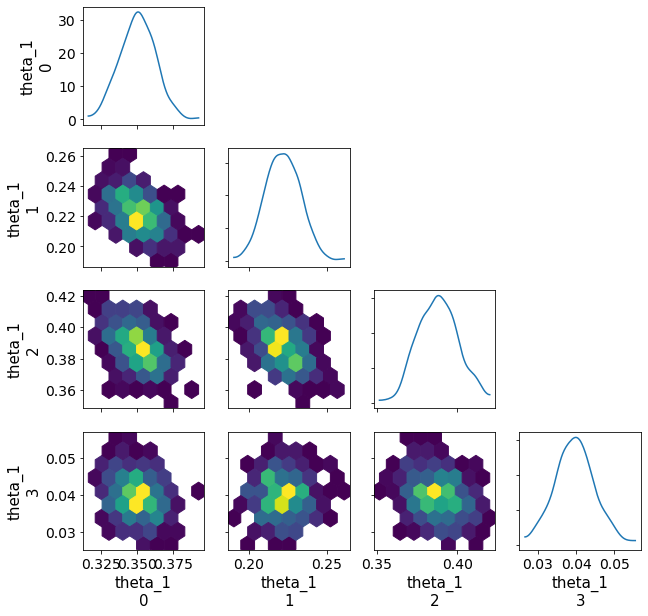

In [41]:
import arviz as az

data = az.from_pyro(mcmc)

az.plot_pair(
    data,
    var_names=["theta_1"],
#     coords={"school": ["Choate", "Phillips Andover"]},
    kind="hexbin",
    marginals=True,
    figsize=(10, 10),
)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='beta', ylabel='N'>, <AxesSubplot:>]],
      dtype=object)

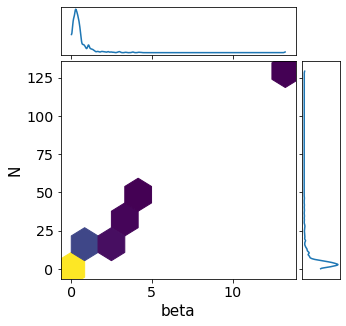

In [42]:
az.plot_pair(
    data,
    var_names=["beta","N"],
#     coords={"school": ["Choate", "Phillips Andover"]},
    kind="hexbin",
    marginals=True,
    figsize=(5, 5),
)

As expected, estimates of beta and N are highly correlated with one another. These two values are not really identifiable.

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='k', ylabel='N'>, <AxesSubplot:>]],
      dtype=object)

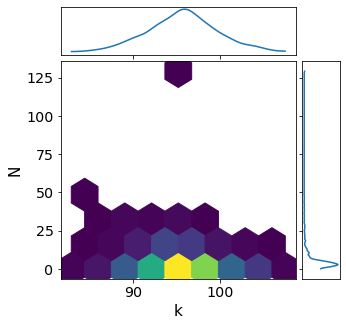

In [43]:
az.plot_pair(
    data,
    var_names=["k","N"],
#     coords={"school": ["Choate", "Phillips Andover"]},
    kind="hexbin",
    marginals=True,
    figsize=(5, 5),
)